In [1]:
import time
import pickle

# https://keras.io/examples/vision/deeplabv3_plus/
import keras
from keras import layers
from keras import ops

import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
os.system("nvcc --version")
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.test.gpu_device_name()


ModuleNotFoundError: No module named 'cv2'

In [2]:
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'
with open(os.path.join(pthDL,'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    classNames = data['classNames']
    
print(classNames)

['islet', 'epithelium', 'vasculature', 'fat', 'acini', 'stroma', 'nontissue', 'PanIN', 'nerves', 'immune', 'PDAC', 'black']


In [7]:
#_______________Create Tensorflow dataset______________

# Paths to training and validation datasets
pthDataset = r'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\test png'



# Define paths to training and validation directories
pthTrain = os.path.join(pthDataset, 'training')
pthValidation = os.path.join(pthDataset, 'validation')

# Get paths to training images and labels
train_images = sorted(glob(os.path.join(pthTrain, 'im', "*.png")))
train_masks = sorted(glob(os.path.join(pthTrain, 'label','corrected_labels', "*.png")))

# Get paths to validation images and labels
val_images = sorted(glob(os.path.join(pthValidation, 'im', "*.png")))
val_masks = sorted(glob(os.path.join(pthValidation, 'label','corrected_labels', "*.png")))

# Define constants
IMAGE_SIZE = 1024
BATCH_SIZE = 4
NUM_TRAIN_IMAGES = len(train_images)  # Number of training images
NUM_VAL_IMAGES = len(val_images)  # Number of validation images

NUM_CLASSES = len(classNames)  # Number of classes



def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>


In [5]:
##_____________________Building the DeepLabV3+ model_______________________________
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 1024,      │          0 │ input_layer[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 1024,      │          0 │ input_layer[0][0] │
│ (GetItem)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 1024,      │          0 │ input_layer[0][0] │
│ (GetItem)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 1024,      │          0 │ get_item[0][0],   │
│                     │ 1024, 3)          │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024,      │          0 │ stack[0][0]       │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 1030,      │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 1030, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 512, 512,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 512, 512,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 512, 512,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 514, 514,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 256, 256,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 256, 256,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 256, 256,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 256, 256,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 256, 256,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,855,180 (45.22 MB)

 Trainable params: 11,822,444 (45.10 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [2]:
# Ensure TensorFlow is set to use the GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth to avoid using all GPU memory
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(f"TensorFlow is using the following GPU: {logical_devices[0]}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available. Ensure that the NVIDIA GPU and CUDA are correctly installed.")


No GPU available. Ensure that the NVIDIA GPU and CUDA are correctly installed.


In [6]:
##_____________________________________Training_____________________________________________________________
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)
start = time.time()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=8)

training_time = time.time() - start
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Epoch 1/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 5134s 17s/step - accuracy: 0.8288 - loss: 0.5239 - val_accuracy: 0.8868 - val_loss: 0.3813
Epoch 2/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 5095s 17s/step - accuracy: 0.9381 - loss: 0.1762 - val_accuracy: 0.9312 - val_loss: 0.2058
Epoch 3/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 6772s 22s/step - accuracy: 0.9510 - loss: 0.1357 - val_accuracy: 0.9410 - val_loss: 0.1667
Epoch 4/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 5166s 17s/step - accuracy: 0.9563 - loss: 0.1190 - val_accuracy: 0.9455 - val_loss: 0.1582
Epoch 5/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 5081s 17s/step - accuracy: 0.9591 - loss: 0.1103 - val_accuracy: 0.9470 - val_loss: 0.1606
Epoch 6/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 5124s 17s/step - accuracy: 0.9624 - loss: 0.0999 - val_accuracy: 0.9474 - val_loss: 0.1564
Epoch 7/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 4984s 16s/step - accuracy: 0.9607 - loss: 0.1052 - val_accuracy: 0.9545 - val_loss: 0.1338
Epoch 8/8
303/303 ━━━━━━━━━━━━━━━━━━━━ 4972s 16s/step - accuracy: 0.9663 - loss: 0.0880 - 

In [24]:
#Save model
print('Saving model...')
data['model'] = model
data['history'] = history.history  # Get the model history
with open(os.path.join(pthDL, 'net.pkl'), 'wb') as f:
    pickle.dump(data, f)


Saving model...


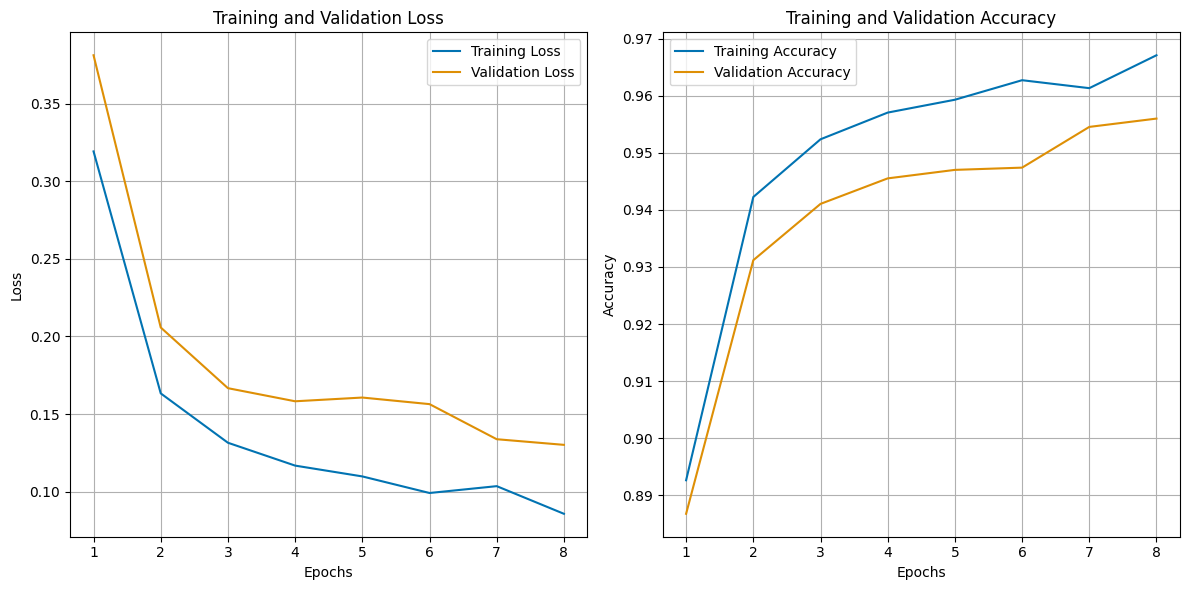

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Accuracy (Training and Validation)
sns.set_palette("colorblind")

# Plot loss and accuracy in a single figure
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
sns.lineplot(data=history.history,x=range(1,len(history.epoch)+1) , y='loss', label='Training Loss')
sns.lineplot(data=history.history,x=range(1,len(history.epoch)+1), y='val_loss', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
sns.lineplot(data=history.history, x=range(1,len(history.epoch)+1), y='accuracy', label='Training Accuracy')
sns.lineplot(data=history.history, x=range(1,len(history.epoch)+1), y='val_accuracy', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
#__________Inference using Colormap Overlay_____________
import numpy as np
# Load colormap
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    model_load = data['model']
    colormap = data['cmap']

colormap = colormap.astype(np.uint8)

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.65, colored_mask, 0.35, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, n_classes=len(classNames)-1)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )   

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


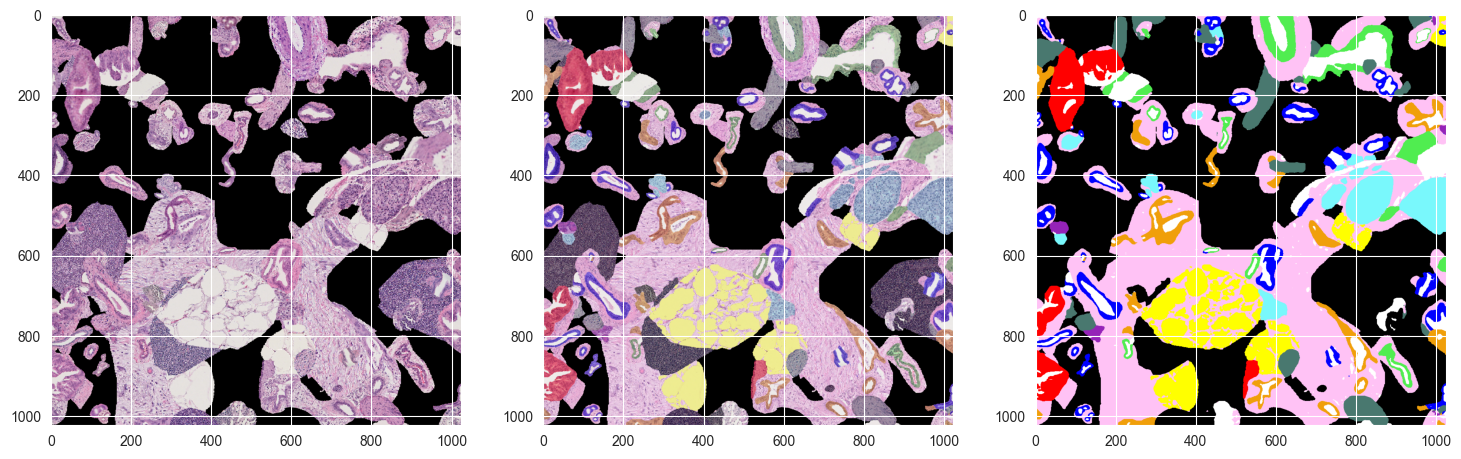

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


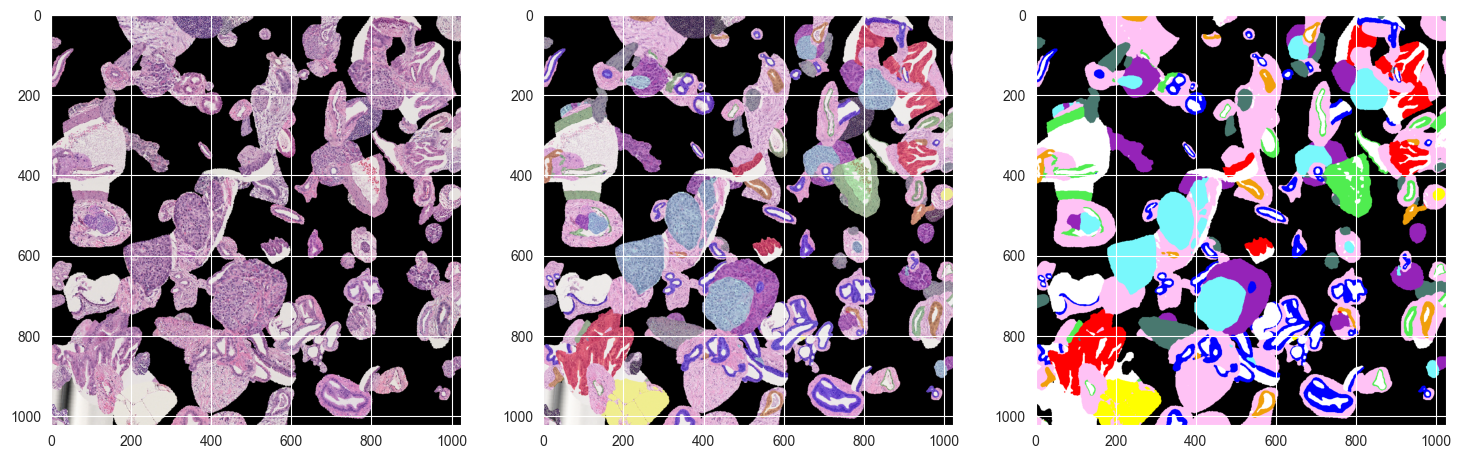

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


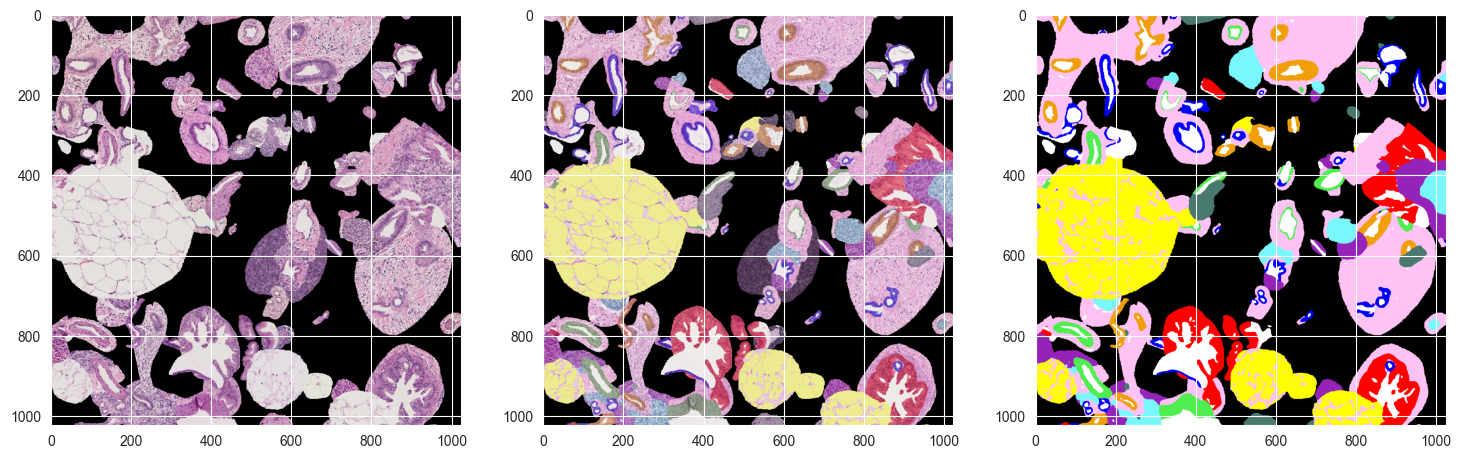

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


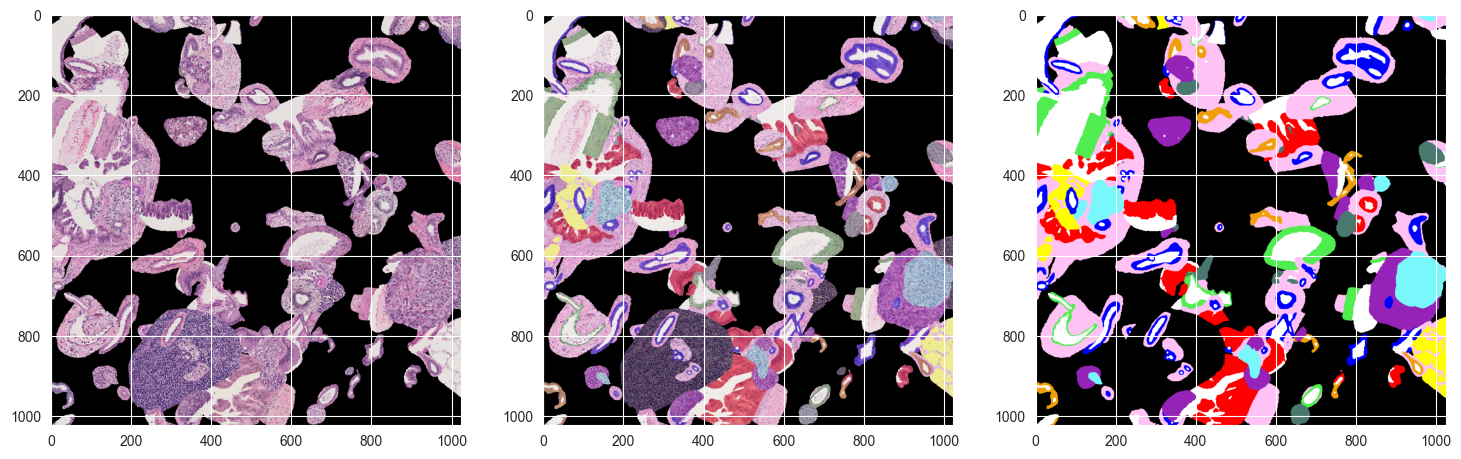

In [9]:
# Inference on 1st 4 training images Train Images
plot_predictions(train_images[:4], colormap, model=model_load)

In [29]:
print(classNames)

['islet', 'epithelium', 'vasculature', 'fat', 'acini', 'stroma', 'nontissue', 'PanIN', 'nerves', 'immune', 'PDAC', 'black']


In [7]:
# BSing
# Iterate over the first batch of the training dataset
for images, labels in train_dataset.take(1):
    # Print the shape of the labels tensor
    print("Labels shape:", labels.shape)

    # Print the unique values in the labels tensor
    unique_labels = tf.unique(tf.reshape(labels, [-1])).y.numpy()
    print("Unique label values:", unique_labels)

    # Print some sample label values
    sample_labels = labels[0].numpy()  # Get the labels for the first image in the batch
    print("Sample label values:\n", sample_labels)
    break  # Break after the first batch

Labels shape: (4, 1024, 1024, 1)
Unique label values: [ 5.  6. 11.  8.  2.  1.  3.  4.  0.  7.  9. 10.]
Sample label values:
 [[[ 5.]
  [ 5.]
  [ 5.]
  ...
  [ 3.]
  [ 3.]
  [ 3.]]

 [[ 5.]
  [ 5.]
  [ 5.]
  ...
  [ 3.]
  [ 3.]
  [ 3.]]

 [[ 5.]
  [ 5.]
  [ 5.]
  ...
  [ 3.]
  [ 3.]
  [ 3.]]

 ...

 [[ 5.]
  [ 5.]
  [ 5.]
  ...
  [10.]
  [10.]
  [10.]]

 [[ 5.]
  [11.]
  [11.]
  ...
  [10.]
  [10.]
  [10.]]

 [[11.]
  [11.]
  [11.]
  ...
  [10.]
  [10.]
  [10.]]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

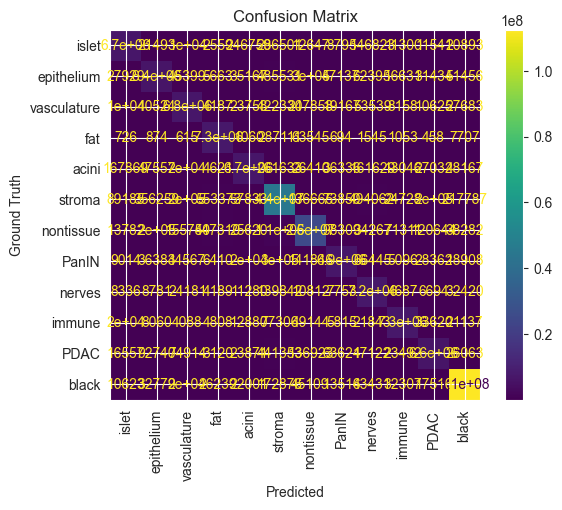

In [3]:
from Plot_confussion_matrix import plot_confusion_matrix
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'

with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    model = data['model']
    classNames = data['classNames']
    tile_size = data['sxy']

# Paths to training and validation datasets:
pthDataset = r'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\test png\validation'

# Get paths to validation images and labels
Validation_HE = sorted(glob(os.path.join(pthDataset, 'im', "*.png")))
Validation_label = sorted(glob(os.path.join(pthDataset, 'label','corrected_labels', "*.png")))

plot_confusion_matrix(Validation_HE,Validation_label,classNames,1024,model)
tenso